# Topic modeling playground
In this notebook, different concepts for topic modeling will be tested and evaluated.

In [1]:
# import libraries used in this notebook

import re

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# preprocessing
import nltk

nltk.download('stopwords')
import spacy

# Plotting
import pyLDAvis.gensim_models

[nltk_data] Downloading package stopwords to /home/debian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Structure

In [2]:
from enum import Enum


class Party(Enum):
    AFD = 0
    CDU = 1
    FDP = 2
    GRUENE = 3
    LINKE = 4
    SPD = 5

## Preprocessing

In [3]:
nlp = spacy.load('de_core_news_md')
from nltk.corpus import stopwords
from spacy.lang.de.stop_words import STOP_WORDS

# stopwords
nltk_stopwords = stopwords.words('german')

# build stopwords list
all_stopwords = list(set(STOP_WORDS) | set(nltk_stopwords))
with open('custom_stopwords.txt', 'r', encoding='utf-8') as f:
    all_stopwords += [line.strip() for line in f.readlines()]

# Load files
party_text = {}
for party in Party:
    all_stopwords.extend(['{}'.format(party.name.lower())])
    with open('../resources/' + party.name + '.txt', encoding='utf-8', errors='ignore') as txt:
        file = " ".join(l for l in txt)
        # remove gender *
        file = re.sub(r'\*innen(\w*)\s', r'\1 ', file)
    party_text[party] = file



In [4]:
def prepare_data(parties: [Party]):
    # get sections
    sections = []
    for partie in parties:
        sections_of_partie = re.split(r'\n\s*\n', party_text[partie])
        sections.extend(sections_of_partie)

    partie_wordbags_mod = []

    for section in sections:
        partie_wordbag = gensim.utils.simple_preprocess(section)

        #filter stopwords
        partie_wordbag_spacy = [word for word in partie_wordbag if word not in all_stopwords]

        partie_wordbags_mod.append(partie_wordbag_spacy)

    # make bigrams / trigrams
    bigram = gensim.models.Phrases(partie_wordbags_mod, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[partie_wordbags_mod], threshold=100)

    bigram_phraser = gensim.models.phrases.Phraser(bigram)
    trigram_phraser = gensim.models.phrases.Phraser(trigram)

    def make_bigrams(texts):
        return [bigram_phraser[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_phraser[bigram_phraser[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent))
            texts_out.append(
                [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ not in all_stopwords])
        return texts_out

    words_trigrams = make_trigrams(partie_wordbags_mod)
    words_lematized = lemmatization(words_trigrams)

    id2word = corpora.Dictionary(words_lematized)
    texts = words_lematized
    corpus = [id2word.doc2bow(text) for text in texts]

    return corpus, id2word, words_lematized

In [5]:

corpus, id2word, words_lematized = prepare_data([Party.FDP])
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            iterations=125
                                            )

lda_model.print_topics(num_topics=10, num_words=10)

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_lematized, dictionary=id2word, coherence='u_mass',
                                     corpus=corpus)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.055300641441159

Coherence Score:  -4.92041639976755


## Visualization

In [6]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/home/debian/PycharmProjects/TextAnalytics/venv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/debian/PycharmProjects/TextAnalytics/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/debian/PycharmProjects/TextAnalytics/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/debian/PycharmProjects/TextAnalytics/venv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.005873  0.043988       1        1  16.773826
7     -0.002979  0.068259       2        1  13.672163
0      0.051973  0.021083       3        1  12.950601
1     -0.020536  0.033647       4        1  11.807827
3      0.049050  0.014461       5        1   9.839767
2     -0.125278  0.003673       6        1   8.626397
5     -0.043588 -0.064802       7        1   8.512551
4      0.046917 -0.028632       8        1   6.862954
8      0.013436 -0.009725       9        1   6.724969
9      0.025132 -0.081954      10        1   4.228945, topic_info=                     Term       Freq      Total Category  logprob  loglift
178                kultur  11.000000  11.000000  Default  30.0000  30.0000
1092            beruflich  15.000000  15.000000  Default  29.0000  29.0000
788                 mobil   6.000000   6.000000  Default  28.0000  28.0000
1116          hochschulen  11.000000  11.000000  Default  27.0000  27.0000
1235  beruflichen_bildung   7.000000   7.000000  Default  26.0000  26.0000
...                   ...        ...        ...      ...      ...      ...
320                privat   1.183808  23.680836  Topic10  -6.0428   0.1673
704                klaren   1.121320  18.156214  Topic10  -6.0970   0.3787
3163                außen   0.975546   9.411990  Topic10  -6.2363   0.8965
312              lösungen   0.935423   9.946101  Topic10  -6.2783   0.7993
3080          integration   0.870820   7.113570  Topic10  -6.3499   1.0629

[747 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
613       1  0.928755  abgabenquote
3645      5  0.393710     abrüstung
3645      8  0.393710     abrüstung
532       2  0.290876   abschließen
532       4  0.290876   abschließen
...     ...       ...           ...
2578      4  0.158044   überwachung
2578      9  0.158044   überwachung
2578     10  0.158044   überwachung
255       1  0.347819   überzeugung
255       6  0.347819   überzeugung

[1638 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 8, 1, 2, 4, 3, 6, 5, 9, 10])

## Other models

In [7]:
lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=id2word, num_topics=10, chunksize=100)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lsi_model, texts=words_lematized, dictionary=id2word, coherence='u_mass',
                                     corpus=corpus)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

lsi_model.print_topics(num_topics=10)


Coherence Score:  -5.359567612732676


[(0,
  '0.288*"unternehmen" + 0.158*"digital" + 0.152*"chancen" + 0.148*"nachhaltig" + 0.142*"entwicklung" + 0.141*"freiheit" + 0.133*"wettbewerb" + 0.133*"digitale" + 0.131*"international" + 0.120*"bildung"'),
 (1,
  '0.357*"bildung" + -0.346*"unternehmen" + 0.296*"schulen" + 0.281*"beruflich" + 0.184*"beruflichen_bildung" + 0.147*"weiterbildung" + 0.140*"hochschulen" + 0.112*"leben" + 0.110*"finanziell" + 0.108*"digital"'),
 (2,
  '-0.437*"unternehmen" + 0.316*"freiheit" + 0.167*"land" + 0.165*"menschenrechte" + -0.164*"altersvorsorge" + -0.135*"gesetzlich" + -0.110*"arbeiten" + 0.108*"global" + 0.104*"nachhaltig" + 0.097*"richtung"'),
 (3,
  '0.234*"unternehmen" + -0.193*"schutz" + 0.153*"bildung" + 0.149*"freiheit" + -0.136*"gewalt" + -0.126*"altersvorsorge" + -0.123*"menschenrechte" + -0.119*"klaren" + -0.114*"polizei" + 0.113*"beruflich"'),
 (4,
  '-0.372*"co" + 0.241*"unternehmen" + 0.208*"freiheit" + -0.191*"klimaschutz" + -0.135*"kraftstoffe" + 0.121*"menschenrechte" + -0.119*

In [8]:
from pprint import pprint

hdp_model = gensim.models.hdpmodel.HdpModel(corpus=corpus, id2word=id2word, )
pprint(hdp_model.show_topics())

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=hdp_model, texts=words_lematized, dictionary=id2word, coherence='u_mass',
                                     corpus=corpus)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0,
  '0.002*technologien + 0.002*bundestag + 0.002*weiterbildung + '
  '0.002*zeitkritische + 0.002*anbieten + 0.002*beruflich + 0.002*soweit + '
  '0.002*beruflichen_bildung + 0.001*co + 0.001*bildung + 0.001*häuslich + '
  '0.001*atommächten + 0.001*kronzeugen + 0.001*entsprechen + 0.001*ambulant + '
  '0.001*entscheidungen + 0.001*regeln + 0.001*unternehmerlohn + '
  '0.001*voraussetzung + 0.001*beobachtung'),
 (1,
  '0.002*niedergelassen + 0.002*personen + 0.002*muslimisch + 0.001*sicherheit '
  '+ 0.001*vorsorgen + 0.001*ideologiefreie + 0.001*nuklear + 0.001*gigabit + '
  '0.001*erleichterungen + 0.001*ansiedlung + 0.001*überangebot + 0.001*lasten '
  '+ 0.001*demokratisch + 0.001*anspruchsvoll + 0.001*strategien + '
  '0.001*behinderungen + 0.001*memorial + 0.001*leitfäden + 0.001*flächen + '
  '0.001*talente'),
 (2,
  '0.002*auszeiten + 0.001*co + 0.001*unternehmen + 0.001*absehbar + '
  '0.001*giftanschläge + 0.001*klimaschutz + 0.001*gefahrenabwehr + '
  '0.001*angehörig + 

# Plot coherence score

In [9]:
from datetime import datetime
import matplotlib.pyplot as plt


def plot_coherence_lda(coherence, max_topics, max_iterations, parties, iteration_intervall=25, save=False):
    corpus, id2word, words_lematized = prepare_data(parties)

    data = {}
    for iterations in range(iteration_intervall, max_iterations, iteration_intervall):
        statistics = {}
        for topics in range(1, max_topics):
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=topics,
                                                        iterations=iterations
                                                        )
            coherence_model_lda = CoherenceModel(model=lda_model, texts=words_lematized, dictionary=id2word,
                                                 coherence=coherence, corpus=corpus)
            coherence_lda = coherence_model_lda.get_coherence()
            statistics[topics] = coherence_lda
        data[iterations] = statistics

    for key, value in data.items():
        plt.plot(list(value.keys()), list(value.values()), label=key)
    plt.legend()
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence score')
    plt.title('Coherence score for different number of topics')

    if save:
        plt.savefig(
            f'../diagrams/coherence_score/lda/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_coherence_score_{coherence}_for_{parties[0]}_{len(parties)}.png')
  
    plt.show()

In [10]:
def plot_coherence_lsi(coherence, max_topics, parties, save=False):
    corpus, id2word, words_lematized = prepare_data(parties)

    statistics = {}
    for topics in range(1, max_topics):
        lsi_model = gensim.models.lsimodel.LsiModel(corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=topics,
                                                    )
        coherence_model_lsi = CoherenceModel(model=lsi_model, texts=words_lematized, dictionary=id2word,
                                             coherence=coherence, corpus=corpus)
        coherence_lsi = coherence_model_lsi.get_coherence()
        statistics[topics] = coherence_lsi

    plt.plot(list(statistics.keys()), list(statistics.values()))
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence score')
    plt.title('Coherence score for different number of topics')

    if save:
        plt.savefig(
            f'../diagrams/coherence_score/lsi/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}_coherence_score_{coherence}_for_{parties[0]}_{len(parties)}.png')
    
    plt.show()

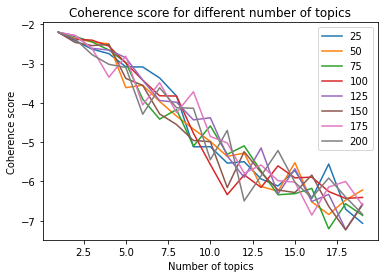

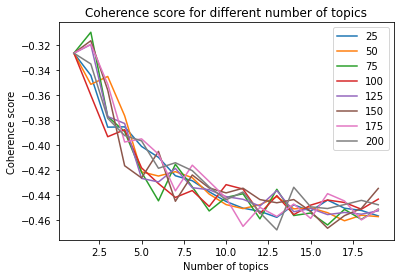

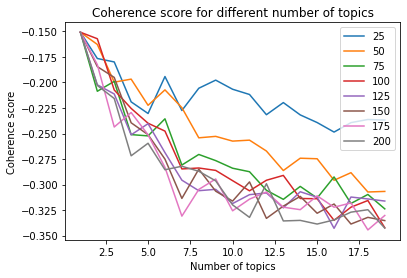

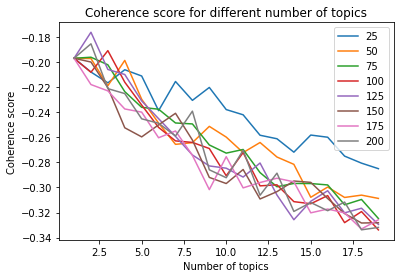

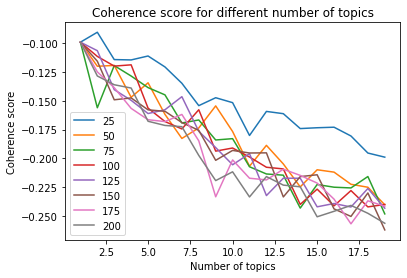

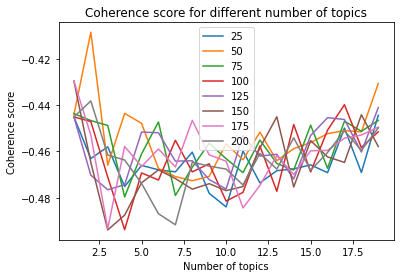

In [11]:
all_parties = [p for p in Party]

plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=all_parties, save=True)
#plot_coherence_lda('c_v', max_iterations=225, max_topics=20, parties=all_parties, save=True)
#plot_coherence_lda('c_uci', max_iterations=225, max_topics=20, parties=all_parties, save=True)
#plot_coherence_lda('c_npmi', max_iterations=225, max_topics=20, parties=all_parties, save=True)

#plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=[Party.SPD], save=True)
#plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=[Party.CDU], save=True)
#plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=[Party.FDP], save=True)
#plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=[Party.GRUENE], save=True)
#plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=[Party.LINKE], save=True)
#plot_coherence_lda('u_mass', max_iterations=225, max_topics=20, parties=[Party.AFD], save=True)

#plot_coherence_lda('c_v', max_iterations=225, max_topics=20, parties=[Party.SPD], save=True)
#plot_coherence_lda('c_v', max_iterations=225, max_topics=20, parties=[Party.CDU], save=True)
#plot_coherence_lda('c_v', max_iterations=225, max_topics=20, parties=[Party.FDP], save=True)
#plot_coherence_lda('c_v', max_iterations=225, max_topics=20, parties=[Party.GRUENE], save=True)
#plot_coherence_lda('c_v', max_iterations=225, max_topics=20, parties=[Party.LINKE], save=True)
#plot_coherence_lda('c_v', max_iterations=225, max_topics=20, parties=[Party.AFD], save=True)

#plot_coherence_lda('c_uci', max_iterations=225, max_topics=20, parties=[Party.SPD], save=True)
#plot_coherence_lda('c_uci', max_iterations=225, max_topics=20, parties=[Party.CDU], save=True)
#plot_coherence_lda('c_uci', max_iterations=225, max_topics=20, parties=[Party.FDP], save=True)
#plot_coherence_lda('c_uci', max_iterations=225, max_topics=20, parties=[Party.GRUENE], save=True)
#plot_coherence_lda('c_uci', max_iterations=225, max_topics=20, parties=[Party.LINKE], save=True)
#plot_coherence_lda('c_uci', max_iterations=225, max_topics=20, parties=[Party.AFD], save=True)

#plot_coherence_lda('c_npmi', max_iterations=225, max_topics=20, parties=[Party.SPD], save=True)
plot_coherence_lda('c_npmi', max_iterations=225, max_topics=20, parties=[Party.CDU], save=True)
plot_coherence_lda('c_npmi', max_iterations=225, max_topics=20, parties=[Party.FDP], save=True)
plot_coherence_lda('c_npmi', max_iterations=225, max_topics=20, parties=[Party.GRUENE], save=True)
plot_coherence_lda('c_npmi', max_iterations=225, max_topics=20, parties=[Party.LINKE], save=True)
plot_coherence_lda('c_npmi', max_iterations=225, max_topics=20, parties=[Party.AFD], save=True)


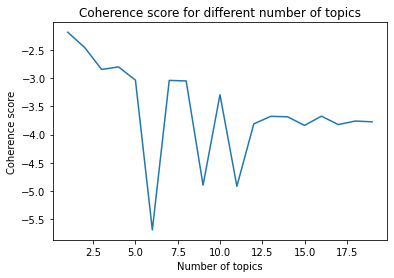

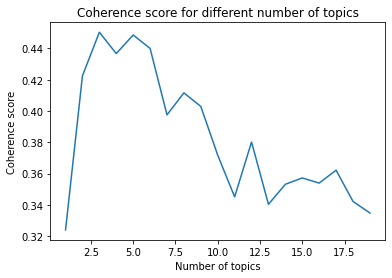

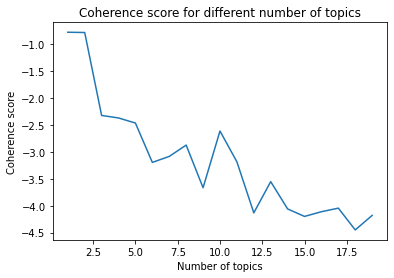

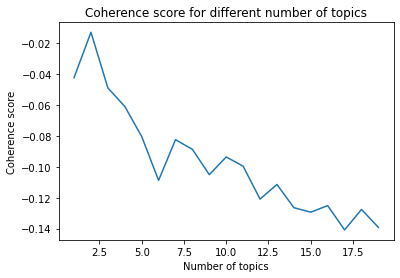

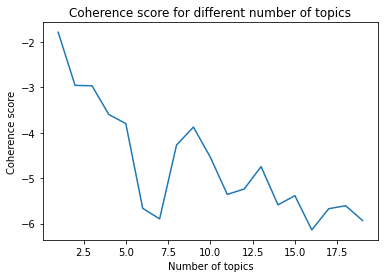

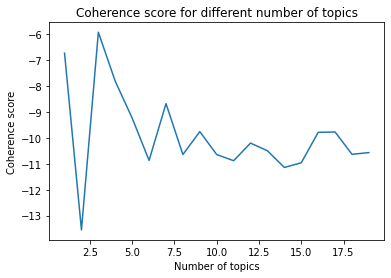

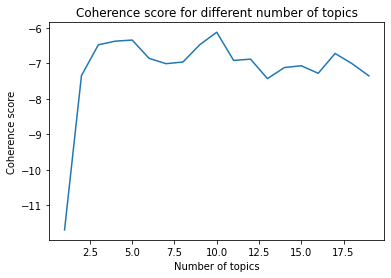

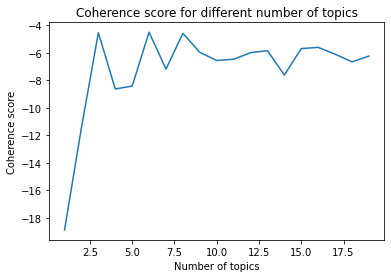

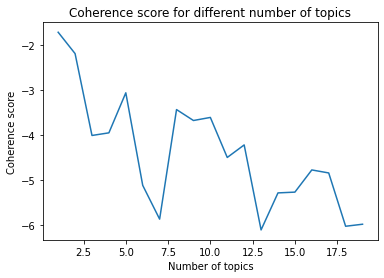

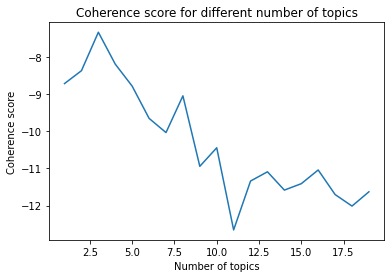

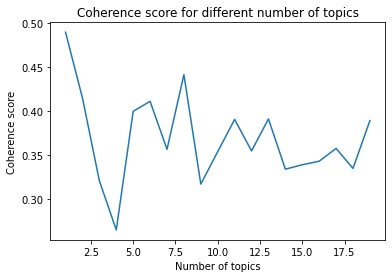

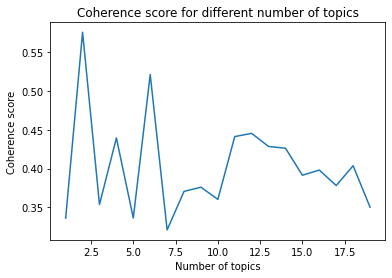

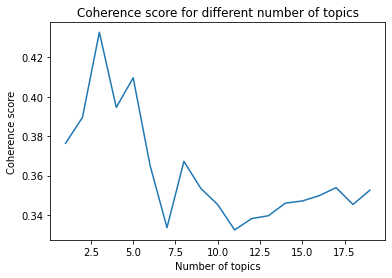

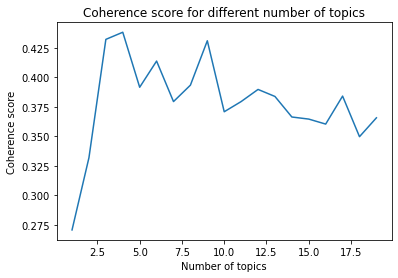

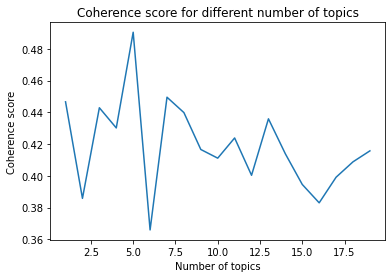

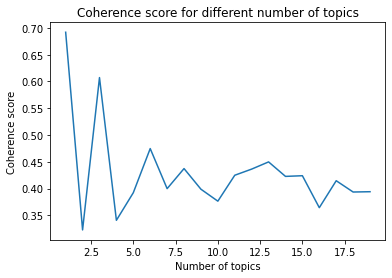

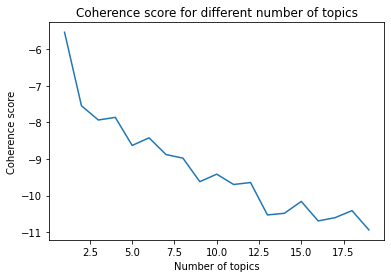

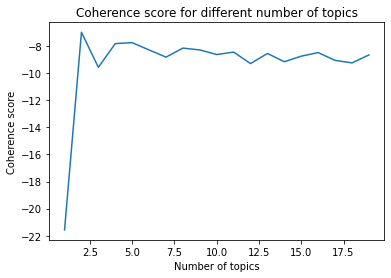

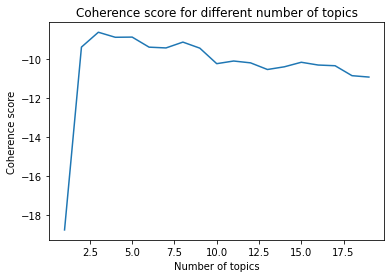

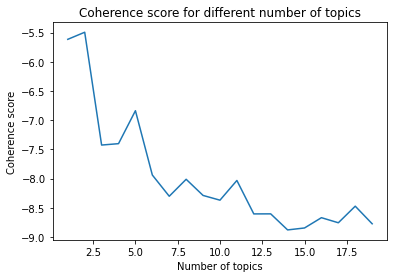

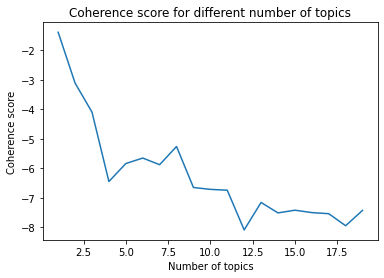

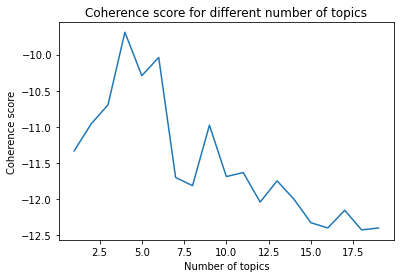

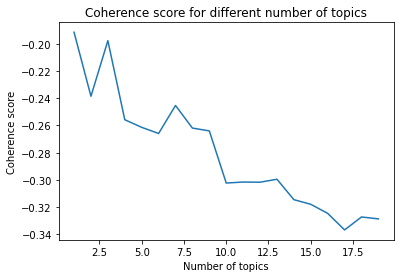

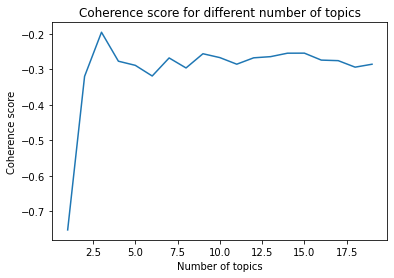

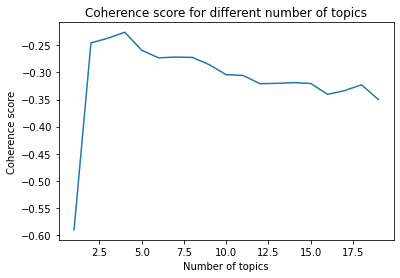

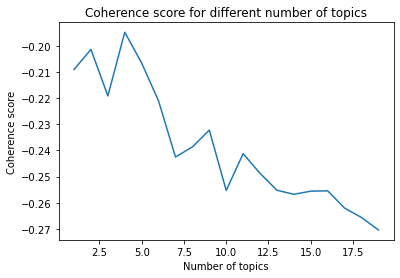

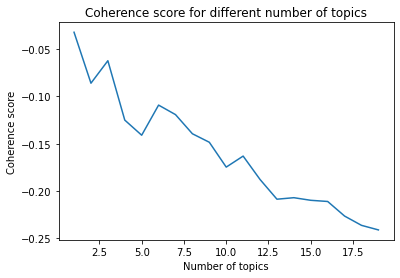

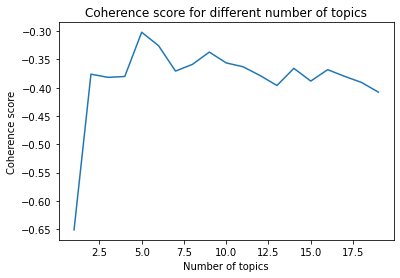

In [12]:
plot_coherence_lsi('u_mass', max_topics=20, parties=all_parties, save=True)
plot_coherence_lsi('c_v', max_topics=20, parties=all_parties, save=True)
plot_coherence_lsi('c_uci', max_topics=20, parties=all_parties, save=True)
plot_coherence_lsi('c_npmi', max_topics=20, parties=all_parties, save=True)

plot_coherence_lsi('u_mass', max_topics=20, parties=[Party.SPD], save=True)
plot_coherence_lsi('u_mass', max_topics=20, parties=[Party.CDU], save=True)
plot_coherence_lsi('u_mass', max_topics=20, parties=[Party.FDP], save=True)
plot_coherence_lsi('u_mass', max_topics=20, parties=[Party.GRUENE], save=True)
plot_coherence_lsi('u_mass', max_topics=20, parties=[Party.LINKE], save=True)
plot_coherence_lsi('u_mass', max_topics=20, parties=[Party.AFD], save=True)

plot_coherence_lsi('c_v', max_topics=20, parties=[Party.SPD], save=True)
plot_coherence_lsi('c_v', max_topics=20, parties=[Party.CDU], save=True)
plot_coherence_lsi('c_v', max_topics=20, parties=[Party.FDP], save=True)
plot_coherence_lsi('c_v', max_topics=20, parties=[Party.GRUENE], save=True)
plot_coherence_lsi('c_v', max_topics=20, parties=[Party.LINKE], save=True)
plot_coherence_lsi('c_v', max_topics=20, parties=[Party.AFD], save=True)

plot_coherence_lsi('c_uci', max_topics=20, parties=[Party.SPD], save=True)
plot_coherence_lsi('c_uci', max_topics=20, parties=[Party.CDU], save=True)
plot_coherence_lsi('c_uci', max_topics=20, parties=[Party.FDP], save=True)
plot_coherence_lsi('c_uci', max_topics=20, parties=[Party.GRUENE], save=True)
plot_coherence_lsi('c_uci', max_topics=20, parties=[Party.LINKE], save=True)
plot_coherence_lsi('c_uci', max_topics=20, parties=[Party.AFD], save=True)

plot_coherence_lsi('c_npmi', max_topics=20, parties=[Party.SPD], save=True)
plot_coherence_lsi('c_npmi', max_topics=20, parties=[Party.CDU], save=True)
plot_coherence_lsi('c_npmi', max_topics=20, parties=[Party.FDP], save=True)
plot_coherence_lsi('c_npmi', max_topics=20, parties=[Party.GRUENE], save=True)
plot_coherence_lsi('c_npmi', max_topics=20, parties=[Party.LINKE], save=True)
plot_coherence_lsi('c_npmi', max_topics=20, parties=[Party.AFD], save=True)